# (Kaggle PetFinder) Bringing the baseline model to the next level: CatBoost on fine-tuned features + Deep Learning 

## Imports

In [1]:
!pip install --upgrade pip -q
!pip install s3fs -q
!pip install -U spacy -q
!python -m spacy download en_core_web_sm -q
!python -m spacy download en -q
!pip install catboost -q
!pip install opencv-python -q

In [87]:
%load_ext autoreload
%autoreload 2

from mxnet_utils import *
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def get_nlp_feats():
    nlp_feats = pd.read_csv("nlp.csv").set_index('petid')
    return nlp_feats[[f for f in nlp_feats.columns if "vec" in f]]
    
def get_cv_feats():
    cv_feats = pd.read_csv("cv.csv").set_index('petid')
    return cv_feats[[f for f in cv_feats.columns if "cv" in f]]

In [3]:
artifacts = load_artifact('artifacts.pkl')
features = artifacts['features']
X_t = artifacts['X_train']
X_v = artifacts['X_valid']
cats_ = artifacts['cat_feats']

In [8]:
cv_feats = get_cv_feats()
cv_feats.shape

(14993, 512)

In [9]:
nlp_feats = get_nlp_feats()
nlp_feats.shape

(14993, 200)

In [6]:
feats = [f for f in features if "vec" not in f and "cv" not in f]

In [71]:
X_train = X_t[feats+['petid', 'adoptionspeed']].set_index('petid').join(cv_feats, how="inner").join(nlp_feats, how="inner")
X_valid = X_v[feats+['petid', 'adoptionspeed']].set_index('petid').join(cv_feats, how="inner").join(nlp_feats, how="inner")

In [8]:
X_train.shape, X_valid.shape

((10870, 734), (4948, 734))

In [72]:
y_train = X_train.adoptionspeed
y_valid = X_valid.adoptionspeed
X_train.drop('adoptionspeed', inplace=True, axis=1)
X_valid.drop('adoptionspeed', inplace=True, axis=1)

assert 'adoptionspeed' not in X_train.columns
assert 'adoptionspeed' not in X_valid.columns

In [11]:
clf = CatBoostClassifier(iterations=2000,
                         learning_rate=0.01,
                         task_type = "GPU",
                         cat_features=cats_,
                         loss_function='MultiClass',
                         custom_metric='Accuracy')
                
clf.fit(X_train, y_train,
        eval_set=(X_valid, y_valid),
        plot=False,
        use_best_model=True,
        verbose=False);

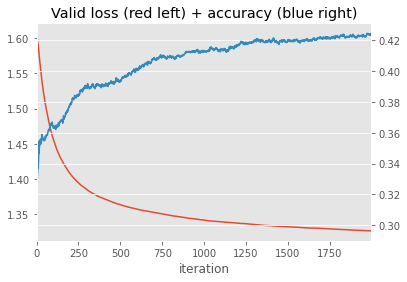

In [12]:
read_catboost().plot(x='iteration', y=['loss_valid', 'accuracy_valid'], secondary_y='accuracy_valid', legend=False, title="Valid loss (red left) + accuracy (blue right)");

Accuracy: 0.42361
Cohen's Kappa: 0.3666
Kaggle winning Cohen's Kappa: 0.45338



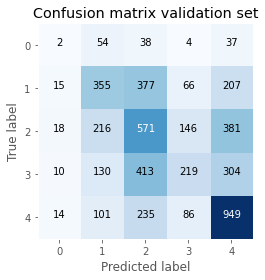

In [13]:
report(clf, X_valid, y_valid)

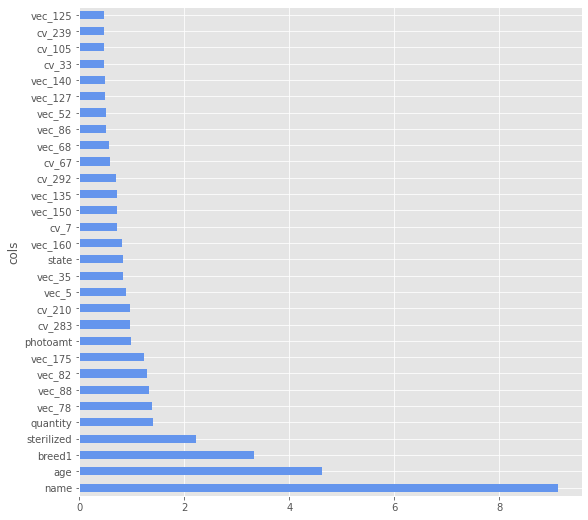

In [14]:
fi = get_feat_importance(clf, X_valid, html=False)
plot_fi(fi[:30]);

In [17]:
%%time
cat = CatBoostClassifier(task_type = "GPU",
                         cat_features=cats_,
                         loss_function='MultiClass')

grid = {'iterations': randint(1500, 3000),
        'depth': randint(4, 10),
        'learning_rate': 10**(np.random.uniform(1, 3, 10) * -1),
        'l2_leaf_reg': randint(2, 20)}

randomized_search_result = cat.randomized_search(grid, X=X_train, y=y_train)

bestTest = 1.327921063
bestIteration = 2765
0:	loss: 1.3279211	best: 1.3279211 (0)	total: 1m 50s	remaining: 16m 33s
bestTest = 1.389044936
bestIteration = 1945
1:	loss: 1.3890449	best: 1.3279211 (0)	total: 6m 23s	remaining: 25m 34s
bestTest = 1.336968753
bestIteration = 2762
2:	loss: 1.3369688	best: 1.3279211 (0)	total: 8m 17s	remaining: 19m 20s
bestTest = 1.107030397
bestIteration = 1942
3:	loss: 1.1070304	best: 1.1070304 (3)	total: 9m 44s	remaining: 14m 37s
bestTest = 1.145633926
bestIteration = 1774
4:	loss: 1.1456339	best: 1.1070304 (3)	total: 10m	remaining: 10m
bestTest = 1.331054238
bestIteration = 1939
5:	loss: 1.3310542	best: 1.1070304 (3)	total: 10m 16s	remaining: 6m 51s
bestTest = 1.322037431
bestIteration = 2004
6:	loss: 1.3220374	best: 1.1070304 (3)	total: 10m 34s	remaining: 4m 31s
bestTest = 1.29031869
bestIteration = 2959
7:	loss: 1.2903187	best: 1.1070304 (3)	total: 14m 18s	remaining: 3m 34s
bestTest = 1.305376911
bestIteration = 2041
8:	loss: 1.3053769	best: 1.1070304 (

In [18]:
randomized_search_result['params']

{'depth': 7.0,
 'learning_rate': 0.08579763290407799,
 'l2_leaf_reg': 10.0,
 'iterations': 2144.0}

Accuracy: 0.42522
Cohen's Kappa: 0.37986
Kaggle winning Cohen's Kappa: 0.45338



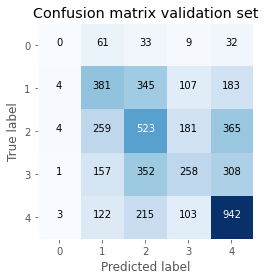

In [19]:
report(cat, X_valid, y_valid)

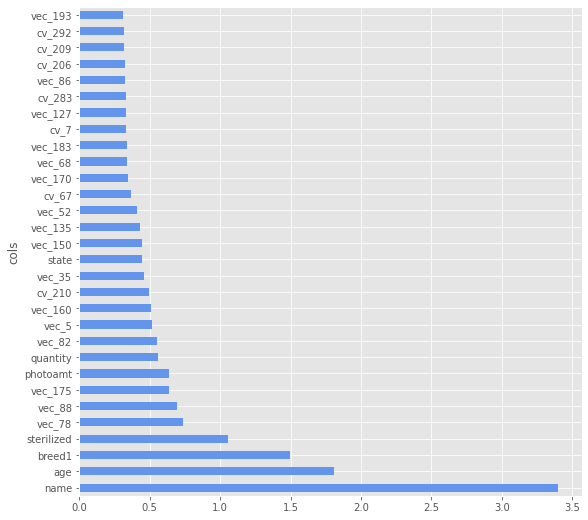

In [20]:
fi = get_feat_importance(cat, X_valid, html=False)
plot_fi(fi[:30]);

## Deep Learning 

In [71]:
ctx = mx.gpu()

In [18]:
cv_feats = get_cv_feats()
nlp_feats = get_nlp_feats()

artifacts = load_artifact('artifacts.pkl')
features = artifacts['features']
feats = [f for f in features if "vec" not in f and "cv" not in f]
raw_train = artifacts['X_train']
raw_valid = artifacts['X_valid']
cats_ = artifacts['cat_feats']

raw_train = raw_train[feats+['petid', 'adoptionspeed']].set_index('petid').join(cv_feats, how="inner").join(nlp_feats, how="inner")
raw_valid = raw_valid[feats+['petid', 'adoptionspeed']].set_index('petid').join(cv_feats, how="inner").join(nlp_feats, how="inner")

y_train = raw_train.adoptionspeed
y_valid = raw_valid.adoptionspeed
raw_train.drop('adoptionspeed', inplace=True, axis=1)
raw_valid.drop('adoptionspeed', inplace=True, axis=1)

assert 'adoptionspeed' not in raw_train.columns
assert 'adoptionspeed' not in raw_valid.columns

In [19]:
raw_train.head()

,age,len_desc,quantity,fee,photoamt,magnitude,name,breed1,breed2,gender,...,vec_190,vec_191,vec_192,vec_193,vec_194,vec_195,vec_196,vec_197,vec_198,vec_199
petid,,,,,,,,,,,,,,,,,,,,,
000fb9572,2,30.0,1,0,6.0,0.8,Minnie,307,0,2,...,-0.204805,-0.120394,-0.203883,0.140123,0.146703,-0.023518,0.004772,-0.256093,0.186037,0.136628
0011d7c25,2,9.0,1,0,3.0,0.8,Spot,241,241,1,...,-0.103921,-0.254193,-0.368831,0.092267,-0.111209,0.021954,-0.141817,-0.156179,0.117617,0.020803
00156db4a,1,82.0,1,0,5.0,1.8,Pup,307,0,1,...,-0.015124,-0.168721,-0.199162,0.106704,0.066061,-0.151983,-0.015352,-0.138054,0.188798,0.097827
001a1aaad,7,121.0,2,0,4.0,3.5,Cookie & Leo,265,0,1,...,0.014736,-0.092469,-0.139565,0.196030,0.020342,-0.177693,-0.008069,-0.107937,0.129181,0.077736
001b1507c,2,148.0,1,50,6.0,4.7,Grey Baby Girl,266,265,2,...,-0.055010,-0.178267,-0.020247,0.081800,0.053436,0.019179,-0.065842,-0.213648,0.174046,0.095165


In [20]:
catf, numf = split_cats(raw_train, cats_)
len(catf), len(numf)

(15, 718)

In [21]:
X_train, d_cats = categorify(raw_train, catf)

In [22]:
X_train.head()

,age,len_desc,quantity,fee,photoamt,magnitude,name,breed1,breed2,gender,...,vec_190,vec_191,vec_192,vec_193,vec_194,vec_195,vec_196,vec_197,vec_198,vec_199
petid,,,,,,,,,,,,,,,,,,,,,
000fb9572,2,30.0,1,0,6.0,0.8,3865,155,1,2,...,-0.204805,-0.120394,-0.203883,0.140123,0.146703,-0.023518,0.004772,-0.256093,0.186037,0.136628
0011d7c25,2,9.0,1,0,3.0,0.8,5454,104,73,1,...,-0.103921,-0.254193,-0.368831,0.092267,-0.111209,0.021954,-0.141817,-0.156179,0.117617,0.020803
00156db4a,1,82.0,1,0,5.0,1.8,4724,155,1,1,...,-0.015124,-0.168721,-0.199162,0.106704,0.066061,-0.151983,-0.015352,-0.138054,0.188798,0.097827
001a1aaad,7,121.0,2,0,4.0,3.5,1533,123,1,1,...,0.014736,-0.092469,-0.139565,0.196030,0.020342,-0.177693,-0.008069,-0.107937,0.129181,0.077736
001b1507c,2,148.0,1,50,6.0,4.7,2401,124,91,2,...,-0.055010,-0.178267,-0.020247,0.081800,0.053436,0.019179,-0.065842,-0.213648,0.174046,0.095165


In [23]:
X_valid, _ = categorify(raw_valid, catf, d_cats)

In [24]:
X_valid.head()

,age,len_desc,quantity,fee,photoamt,magnitude,name,breed1,breed2,gender,...,vec_190,vec_191,vec_192,vec_193,vec_194,vec_195,vec_196,vec_197,vec_198,vec_199
petid,,,,,,,,,,,,,,,,,,,,,
dd7ad37e7,24,28.0,1,0,1.0,1.5,0,140,1,1,...,-0.258114,-0.147105,0.017356,0.133638,0.025135,0.070112,-0.080308,-0.056084,0.122768,-0.063339
518f86025,3,62.0,1,1,2.0,1.0,3556,155,120,1,...,0.048094,-0.160050,-0.161059,0.114607,0.032491,-0.048000,-0.154846,-0.226307,0.194863,0.242098
8ba1566de,1,3.0,5,0,1.0,0.2,0,130,1,3,...,-0.371357,0.053040,-0.145598,0.500731,0.594119,-0.043963,-0.045302,0.137303,0.091446,0.050955
e5bc7aaa8,2,84.0,3,0,3.0,1.1,0,123,1,3,...,0.017502,-0.160287,-0.169785,0.111007,0.130656,-0.108504,0.002038,-0.180873,0.275565,0.238183
a0c9daa0a,2,27.0,1,0,1.0,0.2,6317,155,1,2,...,-0.028276,-0.070629,-0.188597,0.098899,0.029050,-0.132318,-0.021146,-0.273660,0.166280,0.132679


In [25]:
missing_values(X_valid)

,Total,Percent


In [27]:
X_train.name.unique().shape, X_valid.name.unique().shape, len(X_valid.loc[~X_valid.name.isin(X_train.name.unique())])

((6391,), (792,), 2763)

In [28]:
X_train.breed1.unique().shape, X_valid.breed1.unique().shape, len(X_valid.loc[~X_valid.breed1.isin(X_train.breed1.unique())])

((155,), (119,), 33)

In [45]:
#scaler = get_numf_scaler(X_train[numf])

#X_train_sc = scale_numf(X_train, numf, scaler)
#X_valid_sc = scale_numf(X_valid, numf, scaler)
#X_train_sc[numf].mean()

In [100]:
cat_sz = [(c, X_train[c].max()+1) for c in catf]
cat_sz

[('name', 6392),
 ('breed1', 156),
 ('breed2', 121),
 ('gender', 4),
 ('color1', 8),
 ('color2', 8),
 ('color3', 7),
 ('maturitysize', 5),
 ('furlength', 4),
 ('vaccinated', 4),
 ('dewormed', 4),
 ('sterilized', 4),
 ('health', 4),
 ('lang', 6),
 ('state', 15)]

In [101]:
emb_szs = [(c, emb_sz_rule(c)) for _,c in cat_sz]
emb_szs

[(6392, 216),
 (156, 27),
 (121, 23),
 (4, 3),
 (8, 5),
 (8, 5),
 (7, 5),
 (5, 4),
 (4, 3),
 (4, 3),
 (4, 3),
 (4, 3),
 (4, 3),
 (6, 4),
 (15, 7)]

In [51]:
train_ds, valid_ds = get_tab_ds(X_train, y_train, X_valid, y_valid, catf, numf)
train_dl, val_dl = get_tab_dl(train_ds, valid_ds)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/root/mxnet_utils.py:266: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  scaled = scaler.transform(df[numf])
/root/mxnet_utils.py:266: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  scaled = scaler.transform(df[numf])


In [52]:
(x_cat, x_cont), y = next(iter(val_dl))
x_cat.shape, x_cont.shape, y.shape

((256, 15), (256, 718), (256,))

In [54]:
(x_cat, x_cont), y = get_batch(next(iter(val_dl)), ctx, app="tab")
x_cat.shape, x_cont.shape, y.shape

((256, 15), (256, 718), (256,))

In [72]:
#net = get_tabular_model(ctx=ctx, emb_szs=emb_szs, n_cont=len(numf))
#net.summary(x_cat, x_cont)

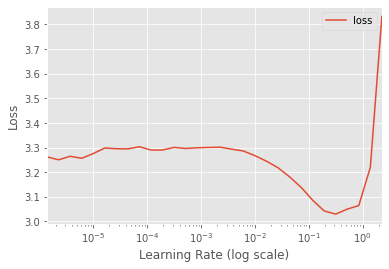

In [66]:
net = get_tabular_model(ctx=ctx, emb_szs=emb_szs, n_cont=len(numf), drops=[0.7,0.7,0.7], emb_drop=0.7)
train_dl, _ = get_tab_dl(train_ds, valid_ds)
df_lrs, min_grad_lr, min_grad_loss = find_lr(net, train_dl, ctx, params=net.collect_params(), app="tab")

In [69]:
model = fine_tune((get_tab_dl(train_ds, valid_ds)), 
                  get_tabular_model(ctx=ctx, emb_szs=emb_szs, n_cont=len(numf), drops=[0.7,0.7,0.7], emb_drop=0.7),
                  lr=3e-4,
                  ctx=ctx,
                  freeze=False,
                  epochs=20,
                  app="tab")

[Epoch 0] Train-acc: 0.207, loss: 3.218 | Val-acc: 0.242, loss: 1.715 | time: 0m:1s
[Epoch 1] Train-acc: 0.214, loss: 2.933 | Val-acc: 0.261, loss: 1.619 | time: 0m:1s
[Epoch 2] Train-acc: 0.222, loss: 2.693 | Val-acc: 0.262, loss: 1.566 | time: 0m:1s
[Epoch 3] Train-acc: 0.234, loss: 2.525 | Val-acc: 0.278, loss: 1.531 | time: 0m:1s
[Epoch 4] Train-acc: 0.249, loss: 2.4 | Val-acc: 0.282, loss: 1.506 | time: 0m:1s
[Epoch 5] Train-acc: 0.254, loss: 2.25 | Val-acc: 0.296, loss: 1.483 | time: 0m:1s
[Epoch 6] Train-acc: 0.25, loss: 2.17 | Val-acc: 0.303, loss: 1.469 | time: 0m:1s
[Epoch 7] Train-acc: 0.259, loss: 2.078 | Val-acc: 0.307, loss: 1.458 | time: 0m:1s
[Epoch 8] Train-acc: 0.261, loss: 1.992 | Val-acc: 0.31, loss: 1.449 | time: 0m:1s
[Epoch 9] Train-acc: 0.268, loss: 1.903 | Val-acc: 0.328, loss: 1.438 | time: 0m:1s
[Epoch 10] Train-acc: 0.266, loss: 1.862 | Val-acc: 0.331, loss: 1.433 | time: 0m:1s
[Epoch 11] Train-acc: 0.269, loss: 1.824 | Val-acc: 0.337, loss: 1.425 | time: 0m

Accuracy: 0.37288
Cohen's Kappa: 0.31161
Kaggle winning Cohen's Kappa: 0.45338



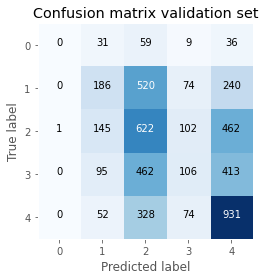

In [98]:
_, valid_dl = get_tab_dl(train_ds, valid_ds)
y_pred = predict(model, valid_dl, ctx=ctx, app="tab")
report(None, None, y_valid, preds=y_pred)